In [209]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random, math
import networkx as nx
from IPython.display import display, clear_output

In [37]:
def correlacion_pearson(data_frame, columna1, columna2):
    return np.corrcoef(data_frame[columna1], data_frame[columna2])[0,1];

# Experimentos del TP de Page Rank
En esta carpeta de Jupyer vamos a poner lo relativo a realizar la experimentación computacional.
- **Asegurarse de correr los experimentos en el notebook Experimentos antes de utilizar este notebook.**
- En este archivo se lee el output de los experimentos y se muestra de manera gráfica esos resultados.

## Funciones a utilizar:

In [165]:
def armar_WD(matriz_path):
    
    data = leer_matriz(matriz_path)
    header = data[0]
    body = data[1]
    
    M = header[0] # Filas y Columnas de matriz
    N = header[1] # Relaciones
    
    W = np.zeros((M, M), dtype=np.float64)
    
    for rel in body:
        W[rel[1]-1][rel[0]-1] = 1
        
    D = np.zeros((M, M), dtype=np.float64)
    C = np.zeros(M, dtype=np.float64)
    
    for j in range(0, M):
        zeroes = 0
        for i in range(0, M):
            if W[i][j] == 1:
                zeroes = zeroes + 1
        C[j] = zeroes
        
    for i in range(0, M):
        if C[i] != 0:
            D[i][i] = float(1/C[i])
            
    WD = np.matmul(W, D)

    return [WD, C, M]

In [166]:
def armar_matriz_A(matriz_WD, vector_C, n_valor, p_valor):
    
    Z = np.zeros(n_valor, dtype=np.float64)
    E = np.ones(n_valor, dtype=np.float64)
    
    for i in range(0, n_valor):
        if vector_C[i] != 0:
            Z[i] = (float((1 - p_valor) / n_valor))
        else:
            Z[i] = (float((1) / n_valor))

    WDp = p_valor*matriz_WD    
    E = np.array(E)[np.newaxis]
    EZt = E.T * Z
    A = WDp + EZt

    return A

In [168]:
def norma_autovector(A, resultado_path):
    solucion_sistema = leer_resultado(resultado_path)
    x = np.array(solucion_sistema[1])
    Ax = A.dot(x)
    Ax_x = Ax - x
    return np.linalg.norm(Ax_x)

In [167]:
def leer_matriz(path_instancia):
    file = open(path_instancia, "r")
    Lines = file.readlines()
    header = [int(Lines[0]), int(Lines[1])]
    Lines = Lines[2:]
    
    relaciones = []
    
    for line in Lines:
        line_data = line.split()
        relaciones.append([int(line_data[0]), int(line_data[1])])
        
    return([header, relaciones])

def leer_resultado(path_instancia):
    file = open(path_instancia, "r")
    Lines = file.readlines()
    
    header = float(Lines[0])
    
    Lines = Lines[1:]
    
    resultados = []
    
    for line in Lines:
        resultados.append(float(line))
        
    return([header, resultados])

In [169]:
def obtener_nodo_central(path_archivo):
    path_data = str(path_archivo).split('.txt')[0]
    path_data = F"{path_data}-data.txt"
    file_data = open(F"{path_data}", "r")
    Lines = file_data.readlines()
    return int(Lines[0])

In [170]:
def obtener_nodos_grupos(path_archivo):
    path_data = str(path_archivo).split('.txt')[0]
    path_data = F"{path_data}-data.txt"
    file_data = open(F"{path_data}", "r")
    Lines = file_data.readlines()
    return [int(Lines[0]), int(Lines[1])]

In [202]:
def error_absoluto_catedra(resultado_catedra, resultado_nuestro):
    solucion_catedra = leer_resultado(resultado_catedra)
    solucion_nuestro = leer_resultado(resultado_nuestro)
    x_catedra = np.array(solucion_catedra[1])
    x_nuestro = np.array(solucion_nuestro[1])

    x_x_prima = x_catedra - x_nuestro
    return np.linalg.norm(x_x_prima)

# Datasets
Para los experimentos se crean las siguientes familias de instancias para evaluar los distintos métodos.
Para estos experimentos se toman multiples instancias en donde hay 20 o mas negocios:

1. **grupos**: Instancia en la cual las páginas están agrupadas en subconjuntos
2. **ref-one-ref-lot-diversity**: Las páginas estan enlazadas y entre ellas  hay una que es la que más enlaces tiene, a su vez, esa enlaza a una sola página que no enlaza ni es enlazada a ninguna otra
3. **ref-one-ref-lot**: Lo mismo que el anterior, solo que las páginas no estan enlazadas entre si
4. **referenciadas**: Hay páginas más referenciadas que el resto
5. **una-sola**: Todas las páginas estan enlazadas a una sola

Por cada una de estas tenemos casos valuados en el valor p:
1. **random**: Uso de un p random
1. **pbajo**: Uso de un p bajo
1. **palto**: Uso de un p alto

# Experimentos

## Graficos. Unas más enlazadas que otras - Referenciadas

In [327]:
pg_resultados = pd.read_csv("resultados/resultado.csv");

In [282]:
exp_referenciadas = pg_resultados[(pg_resultados["dataset"]=="referenciadas")].copy();
n_exps = exp_referenciadas["n_exp"].unique()

In [283]:
n_exps
exps = []
for exp in n_exps:
    exps.append(exp)
    
n_exps = random.sample(exps, 5)

In [284]:
referenciadas_data = []
referenciadas_normas = []
referenciadas_condicion = []

num = 0
# Vamos cada experimento por cada caso
for exp in n_exps:
    
    # Obtengo todos los datos de un experimento
    experimentos = exp_referenciadas[exp_referenciadas["n_exp"] == exp]
    experimento = (experimentos.head(1)).iloc[0]

    # Tengo los experimentos, imprimo todos los resultados y ubico especialmente el P en medio de ello
    experimento_num_arr = []
    experimento_num_normas = []
    experimento_num_condition = []

    # WD_object = [WD, C, M]
    WD_object = armar_WD(experimento["path"])
    
    # Tomo cada fila
    for i in range(0, len(experimentos)):
        clear_output(wait=True)
        display("Numero de iteracion de experimento: " + str(num) + " es: " + str(i))
        item = experimentos.iloc[i]

         # Obtengo la probabilidad
        p_valor = item["p-valor"]
        
        # Obtengo el nodo central
        nodo_central = obtener_nodo_central(item["path"])

        print(item["path-out"])
        # Armo la matriz A que depende de la probabilidad
        matriz_A = armar_matriz_A(WD_object[0], WD_object[1], WD_object[2], p_valor)
    
        numeroCondicion_A = matriz_A

        # Calculo la diferencia |Ax - x|
        norma = norma_autovector(matriz_A, item["path-out"])
        
        # Leemos los resultados del experimento
        lst = []
        with open(item["path-out"]) as f:
            lst = [float(x) for x in f.read().split()]
            
        # De la lista de resultados tomo el nodo de interes
        valor_interes = lst[nodo_central]
        
        # Armo una tupla con ese valor y lo guardo en un arreglo
        experimento_num_arr.append([p_valor, valor_interes])
        experimento_num_normas.append([p_valor, norma])
        experimento_num_condition.append([p_valor, numeroCondicion_A])

    num += 1
    # Guardo los arreglos de cada tupla
    referenciadas_data.append(experimento_num_arr)
    referenciadas_normas.append(experimento_num_normas)
    referenciadas_condicion.append(experimento_num_condition)

'Numero de iteracion de experimento: 4 es: 99'

instancias/referenciadas/referenciadas-27/Test-referenciadas-27.txt.out-99


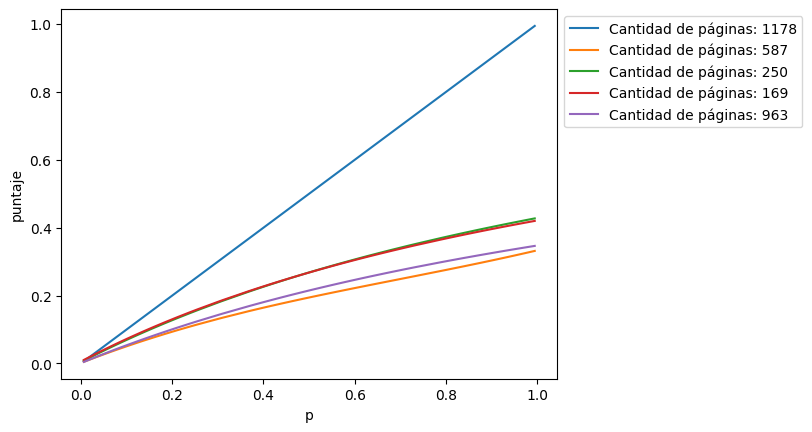

In [308]:
# Imprimo el grafico de valores del nodo central
for i in range(0, len(referenciadas_data)):
    num_exp = n_exps[i]
    
    experimentos = exp_referenciadas[exp_referenciadas["n_exp"] == num_exp]
    experimento = (experimentos.head(1)).iloc[0]
    paginas = experimento["n"]
    
    df_referenciadas_data = pd.DataFrame(referenciadas_data[i], columns=["p", "puntaje"]);

    name = F"Cantidad de páginas: {paginas}"
    fig = sns.lineplot(
        data=df_referenciadas_data, 
        x='p', 
        y='puntaje',
        label=name
    );
    sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))
    
fig.set(xlabel='p', ylabel='puntaje');
plt.savefig("graficos/referenciadas-caso.svg", bbox_inches = 'tight');


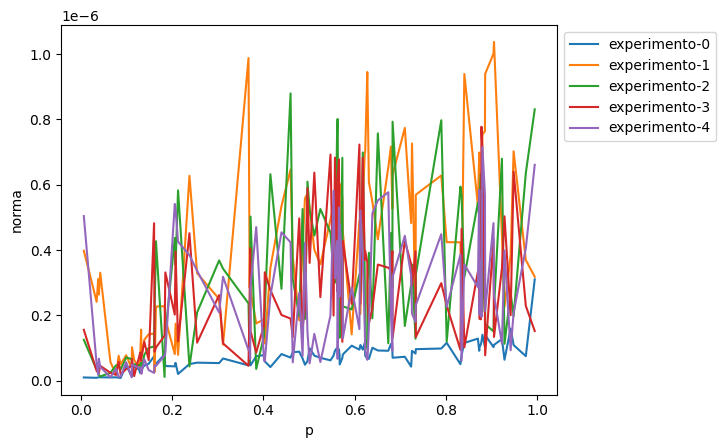

In [311]:
# Imprimo el grafico de las normas de la diferencia Ax - x
for i in range(0, len(referenciadas_normas)):
    df_referenciadas_norma = pd.DataFrame(referenciadas_normas[i], columns=["p", "norma"]);
    # df_resultados.to_csv("resultados/resultado-ref.csv");

    name = F"experimento-{i}"
    # Lineplot
    fig = sns.lineplot(
        data=df_referenciadas_norma, 
        x='p', 
        y='norma',
        label=name
    );
    sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))
    #fig = sns.scatterplot(data=pg_unasola_res, x='p', y='puntaje');
    
fig.set(xlabel='p', ylabel='norma');
plt.savefig("graficos/referenciadas-caso-error.svg", bbox_inches = 'tight');

# Grafico de 15 y 30 segundos

In [112]:
pg_resultados_segundos = pd.read_csv("resultados/resultado-segundos.csv");
n_exps = [1, 2]

In [111]:
referenciadas_segundos_data = []
referenciadas_segundos_normas = []
referenciadas_segundos_condicion = []

# Vamos cada experimento por cada caso
for exp in n_exps:
    
    # Obtengo todos los datos de un experimento
    experimentos = pg_resultados_segundos[pg_resultados_segundos["n_exp"] == exp]

    # Tengo los experimentos, imprimo todos los resultados y ubico especialmente el P en medio de ello
    experimento_num_arr = []
    experimento_num_normas = []
    experimento_num_condition = []
    
    experimento = (experimentos.head(1)).iloc[0]
    
    # WD_object = [WD, C, M]
    WD_object = armar_WD(experimento["path"])

    # Tomo cada fila
    for i in range(0, len(experimentos)):
        clear_output(wait=True)
        display("Numero de iteracion es: " + str(i))
        item = experimentos.iloc[i] 

        # Obtengo la probabilidad
        p_valor = item["p-valor"]

        # Armo la matriz A que depende de la probabilidad
        matriz_A = armar_matriz_A(WD_object[0], WD_object[1], WD_object[2], p_valor)

        # Numero de condicion de la matriz A
        numeroCondicion_A = np.linalg.cond(matriz_A, None)
        if(str(numeroCondicion_A) == 'inf'):
            numeroCondicion_A = 0

        # Calculo la diferencia |Ax - x|
        print(item["path-out"])
        norma = norma_autovector(matriz_A, item["path-out"])
        
        # Leemos los resultados del experimento
        lst = []
        with open(item["path-out"]) as f:
            lst = [float(x) for x in f.read().split()]
            
        for j in range(0, len(lst)):
            experimento_num_arr.append([j, lst[j]])
        # Armo una tupla con ese valor y lo guardo en un arreglo
        experimento_num_normas.append([p_valor, norma])
        experimento_num_condition.append([p_valor, numeroCondicion_A])

    # Guardo los arreglos de cada tupla
    referenciadas_segundos_data.append(experimento_num_arr)
    referenciadas_segundos_normas.append(experimento_num_normas)
    referenciadas_segundos_condicion.append(experimento_num_condition)

n_exp                                                       1
dataset                                      test-15-segundos
n                                                        2000
M                                                       12000
p-valor                                              0.653346
path         instancias/test-15-segundos/test-15-segundos.txt
path-out    instancias/test-15-segundos/test-15-segundos.t...
Name: 0, dtype: object
n_exp                                                       2
dataset                                      test-30-segundos
n                                                        3000
M                                                       18000
p-valor                                              0.653346
path         instancias/test-30-segundos/test-30-segundos.txt
path-out    instancias/test-30-segundos/test-30-segundos.t...
Name: 50, dtype: object


In [108]:
nombres = ["Test-15-segundos", "Test-30-segundos"]
# Imprimo el grafico de las normas de la diferencia Ax - x
for i in range(0, len(referenciadas_segundos_normas)):
    df_segundos_normas = pd.DataFrame(referenciadas_segundos_normas[i], columns=["p", "norma"]);
    # df_resultados.to_csv("resultados/resultado-ref.csv");
    # Lineplot
    fig = sns.lineplot(
        data=df_segundos_normas, 
        x='p', 
        y='norma',
        label=nombres[i]
    );
    sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))
    #fig = sns.scatterplot(data=pg_unasola_res, x='p', y='puntaje');
    
fig.set(xlabel='p', ylabel='norma');
plt.savefig("graficos/test-15-30-segundos-error.svg");

<Figure size 640x480 with 0 Axes>

In [109]:
# Imprimo los numeros de condicion
for i in range(0, len(referenciadas_segundos_condicion)):
    df_segundos_condicion = pd.DataFrame(referenciadas_segundos_condicion[i], columns=["p", "numero_condicion"]);
    # df_resultados.to_csv("resultados/resultado-ref.csv");

    name = F"experimento-{i}"
    # Lineplot
    fig = sns.lineplot(
        data=df_segundos_condicion, 
        x='p', 
        y='numero_condicion',
        label=nombres[i]
    ); 
    sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))
    #fig = sns.scatterplot(data=pg_unasola_res, x='p', y='puntaje');
    
fig.set(xlabel='p', ylabel='numero_condicion');
plt.savefig("graficos/test-15-30-segundos-condicion.svg");

<Figure size 640x480 with 0 Axes>

## Graficos. Unas más enlazadas que otras con n creciente

In [328]:
pg_resultados_n = pd.read_csv("resultados/resultado-n.csv");

In [329]:
exp_referenciadas_n = pg_resultados_n[(pg_resultados_n["dataset"]=="referenciadas-n")].copy();
n_exps_referenciadas = exp_referenciadas_n["n_exp"].unique()

In [330]:
print(n_exps_referenciadas)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96
 97 98 99]


In [177]:
referenciadas_n_data = []
referenciadas_n_normas = []
referenciadas_n_condicion = []
num = 0

# Vamos cada experimento por cada caso
for exp in n_exps_referenciadas:
    
    # Obtengo todos los datos de un experimento
    experimentos = exp_referenciadas_n[exp_referenciadas_n["n_exp"] == exp]

    # Tengo los experimentos, imprimo todos los resultados y ubico especialmente el P en medio de ello
    experimento_num_arr = []
    experimento_num_normas = []
    experimento_num_condition = []
    
    experimento = (experimentos.head(1)).iloc[0]
            
    # WD_object = [WD, C, M]
    WD_object = armar_WD(experimento["path"])

    # Tomo cada fila
    for i in range(0, len(experimentos)):
        clear_output(wait=True)
        display("Numero de iteracion de experimento: " + str(num) + " es: " + str(i))
        item = experimentos.iloc[i] 

        # Obtengo la probabilidad
        p_valor = item["p-valor"]
        
        # Obtengo el nodo central
        nodo_central = obtener_nodo_central(item["path"])

        # Armo la matriz A que depende de la probabilidad
        matriz_A = armar_matriz_A(WD_object[0], WD_object[1], WD_object[2], p_valor)

        # Numero de condicion de la matriz A
        numeroCondicion_A = np.linalg.cond(matriz_A, None)
        #if np.linalg.det(matriz_A) != float(0):
        #    A_inverse = np.linalg.inv(matriz_A)
        #    A_norm = np.linalg.norm(matriz_A) # Busco la norma de A
        #    A_inverse_norm = np.linalg.norm(A_inverse) # Busco la norma de A^-1
        #    numeroCondicion_A = np.multiply(A_norm, A_inverse_norm) # Hago el producto de ambos resultados

        # Calculo la diferencia |Ax - x|
        norma = norma_autovector(matriz_A, item["path-out"])
        
        # Leemos los resultados del experimento
        lst = []
        with open(item["path-out"]) as f:
            lst = [float(x) for x in f.read().split()]
            
        # De la lista de resultados tomo el nodo de interes
        valor_interes = lst[nodo_central]
        
        # Armo una tupla con ese valor y lo guardo en un arreglo
        experimento_num_arr.append([p_valor, valor_interes])
        experimento_num_normas.append([p_valor, norma])
        experimento_num_condition.append([p_valor, numeroCondicion_A])

    # Guardo los arreglos de cada tupla
    referenciadas_n_data.append(experimento_num_arr)
    referenciadas_n_normas.append(experimento_num_normas)
    referenciadas_n_condicion.append(experimento_num_condition)
    num += 1

'Numero de iteracion de experimento: 98 es: 99'

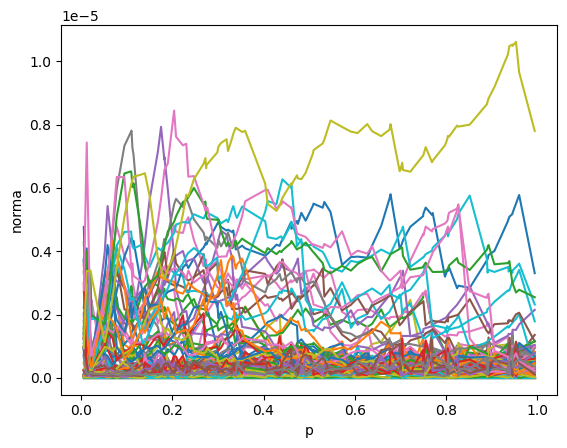

In [178]:
# Imprimo las normas
for i in range(0, len(referenciadas_n_normas)):
    df_referenciadas_n_normas = pd.DataFrame(referenciadas_n_normas[i], columns=["p", "norma"]);
    # df_resultados.to_csv("resultados/resultado-ref.csv");

    name = F"experimento-{i}"
    # Lineplot
    fig = sns.lineplot(
        data=df_referenciadas_n_normas, 
        x='p', 
        y='norma',
    );   
    #fig = sns.scatterplot(data=pg_unasola_res, x='p', y='puntaje');
    
fig.set(xlabel='p', ylabel='norma');
plt.savefig("graficos/referenciadas-n-caso-error.svg");

'p-valor representado: 0.3390999099416755'

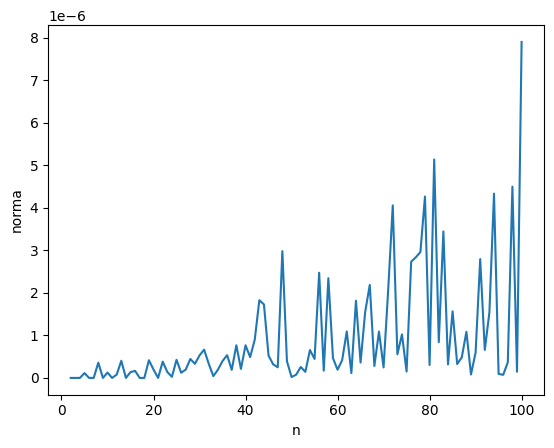

In [179]:
# Busco los "n"
referenciadas_n_values = []
referenciadas_nv_values = []

for exp in n_exps_referenciadas:
    # Obtengo todos los datos de un experimento
    pg_exp_num = exp_referenciadas_n[exp_referenciadas_n["n_exp"] == exp]
        
    # Tengo los experimentos, imprimo todos los resultados y ubico especialmente el P en medio de ello
    pg_exp_num_list = pg_exp_num.values.tolist();
    pg_exp_arr = []
    
    pg_exp_norms = []
    
    n_value = pg_exp_num_list[0][2]
    referenciadas_n_values.append(n_value)
    
# Obtenidos los n, fijo un p. ¿Cual? Uso un random
# p_fijo = random.randint(0, num_exps)
p_fijo = 40
p_val = 0
for i in range(0, len(referenciadas_n_normas)):
    norm_arr = referenciadas_n_normas[i]
    norma_aux = norm_arr[p_fijo]
    p_val = norma_aux[0]
    referenciadas_nv_values.append([referenciadas_n_values[i], norma_aux[1]])

df_unasola_norm_n_res = pd.DataFrame(referenciadas_nv_values, columns=["n", "norma"]);
# df_resultados.to_csv("resultados/resultado-ref.csv");

# Lineplot
fig = sns.lineplot(
    data=df_unasola_norm_n_res, 
    x='n', 
    y='norma',
)
#fig = sns.scatterplot(data=pg_unasola_res, x='p', y='puntaje');

display('p-valor representado: ' + str(p_val))

fig.set(xlabel='n', ylabel='norma');
plt.savefig("graficos/referenciadas-n-caso-error-n.svg");

'p-valor representado: 0.3390999099416755'

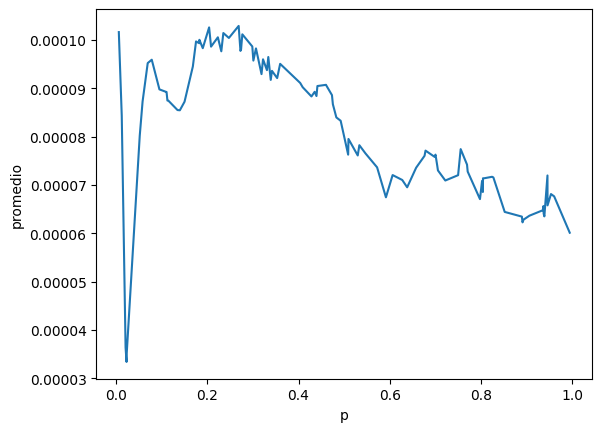

In [180]:
# Para cada p, hacer el promedio entre todos los exp y graficar eso
# Busco los "n"
p_valores = exp_referenciadas_n["p-valor"].unique()
referenciadas_p_valores_pos = [[] for _ in range(len(p_valores))]
num = 0
for i in range(0, len(referenciadas_n_normas)):
    item = referenciadas_n_normas[i]
    for j in range(0, len(item)):
        action = item[j]
        referenciadas_p_valores_pos[j].append(action[1])
        
promedios = []

for i in range(0, len(referenciadas_p_valores_pos)):
    suma_s = 0
    item = referenciadas_p_valores_pos[i]
    for j in range(0, len(item)):
        suma_s += item[j]
    promedios.append(suma_s)
    
resultado_final = []
for i in range(0, len(promedios)):
    resultado_final.append([p_valores[i], promedios[i]])
    
df_referenciada_prom_n = pd.DataFrame(resultado_final, columns=["p", "promedio"]);
# df_resultados.to_csv("resultados/resultado-ref.csv");

name = F"experimento-{i}"
# Lineplot
fig = sns.lineplot(
    data=df_referenciada_prom_n, 
    x='p', 
    y='promedio',
);
#fig = sns.scatterplot(data=pg_unasola_res, x='p', y='puntaje');

display('p-valor representado: ' + str(p_val))

fig.set(xlabel='p', ylabel='promedio');
plt.savefig("graficos/referenciadas-n-caso-error-n-prom.svg");

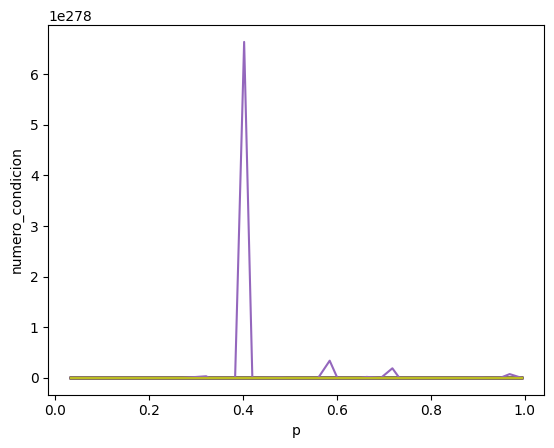

In [143]:
# Imprimo los numeros de condicion
for i in range(0, len(referenciadas_n_condicion)):
    dc_referenciadas_n_condicion = pd.DataFrame(referenciadas_n_condicion[i], columns=["p", "numero_condicion"]);
    # df_resultados.to_csv("resultados/resultado-ref.csv");

    name = F"experimento-{i}"
    # Lineplot
    fig = sns.lineplot(
        data=dc_referenciadas_n_condicion, 
        x='p', 
        y='numero_condicion'
    );   
    #fig = sns.scatterplot(data=pg_unasola_res, x='p', y='puntaje');
    
#plt.axis([0, 1, 0, 100])
fig.set(xlabel='p', ylabel='numero_condicion');
plt.savefig("graficos/referenciadas-n-caso-condicion-n.svg");

# Grafico one ref one lot

In [382]:
exp_rorl = pg_resultados[(pg_resultados["dataset"]=="ref-one-ref-lot")].copy();
n_exps = exp_rorl["n_exp"].unique()

### Experimento 1

'Numero de iteracion es: 99'

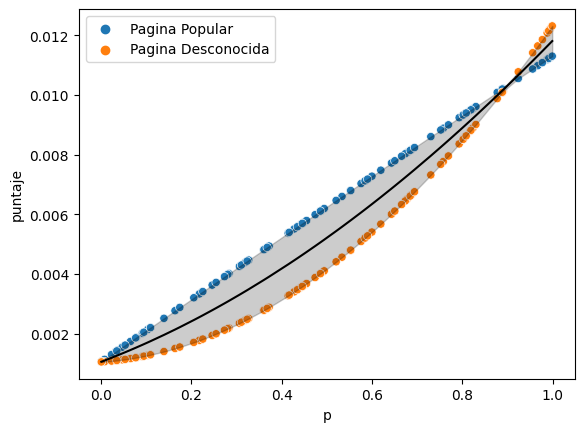

In [383]:
 # Obtengo todos los datos de un experimento
exp_one = exp_rorl[exp_rorl["n_exp"] == n_exps[0]]
one_ref_one_lot_data = []

# Tomo cada fila
for i in range(0, len(exp_one)):
    clear_output(wait=True)
    display("Numero de iteracion es: " + str(i))

    item = exp_one.iloc[i] 
    # Obtengo el data para tener el nodo central

    # Obtengo la probabilidad
    p_valor = item["p-valor"]

    [nodo_central, nodo_ref_central] = obtener_nodos_grupos(item["path"])
    # Leemos los resultados del experimento
    lst = []
    with open(item["path-out"]) as f:
        lst = [float(x) for x in f.read().split()]
        
    # Tengo la lista de los valores, ahora solo me queda buscar aquel que me sirva
    # Accedo con el valor de interes
    valor_central = lst[nodo_central]
    valor_ref_central = lst[nodo_ref_central]

    # Armo una tupla con ese valor y lo guardo en un arreglo
    one_ref_one_lot_data.append([p_valor, valor_central, "Pagina Popular"])
    one_ref_one_lot_data.append([p_valor, valor_ref_central, "Pagina Desconocida"])

paleta = ["blue", "orange"]

df_rorl_res = pd.DataFrame(one_ref_one_lot_data, columns=["p", "puntaje", "indice"]);
# df_resultados.to_csv("resultados/resultado-ref.csv");

# Lineplot
fig = sns.scatterplot(data=df_rorl_res, x='p', y='puntaje', hue="indice");
fig = sns.lineplot(data=df_rorl_res, x='p', y='puntaje', color="black");

fig.set(xlabel='p', ylabel='puntaje');
plt.savefig("graficos/caso_ref-one-ref-lot-1.svg");

### Experimento 2

'Numero de iteracion es: 99'

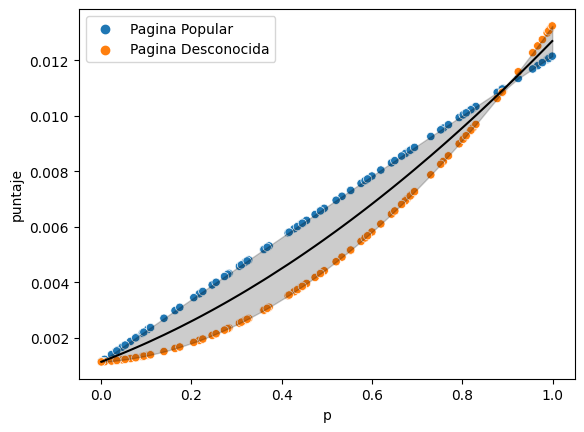

In [384]:
 # Obtengo todos los datos de un experimento
exp_one = exp_rorl[exp_rorl["n_exp"] == n_exps[1]]
one_ref_one_lot_data = []

# Tomo cada fila
for i in range(0, len(exp_one)):
    clear_output(wait=True)
    display("Numero de iteracion es: " + str(i))

    item = exp_one.iloc[i] 
    
    
    # Obtengo el data para tener el nodo central

    # Obtengo la probabilidad
    p_valor = item["p-valor"]

    [nodo_central, nodo_ref_central] = obtener_nodos_grupos(item["path"])
    
    # Leemos los resultados del experimento
    lst = []
    with open(item["path-out"]) as f:
        lst = [float(x) for x in f.read().split()]

    # Tengo la lista de los valores, ahora solo me queda buscar aquel que me sirva

    # Accedo con el valor de interes
    valor_central = lst[nodo_central]
    valor_ref_central = lst[nodo_ref_central]

    # Armo una tupla con ese valor y lo guardo en un arreglo
    one_ref_one_lot_data.append([p_valor, valor_central, "Pagina Popular"])
    one_ref_one_lot_data.append([p_valor, valor_ref_central, "Pagina Desconocida"])

paleta = ["blue", "orange"]

df_rorl_res = pd.DataFrame(one_ref_one_lot_data, columns=["p", "puntaje", "indice"]);
# df_resultados.to_csv("resultados/resultado-ref.csv");

# Lineplot
fig = sns.scatterplot(data=df_rorl_res, x='p', y='puntaje', hue="indice");
fig = sns.lineplot(data=df_rorl_res, x='p', y='puntaje', color="black");

fig.set(xlabel='p', ylabel='puntaje');
plt.savefig("graficos/caso_ref-one-ref-lot-2.svg");

### Experimento 3

'Numero de iteracion es: 99'

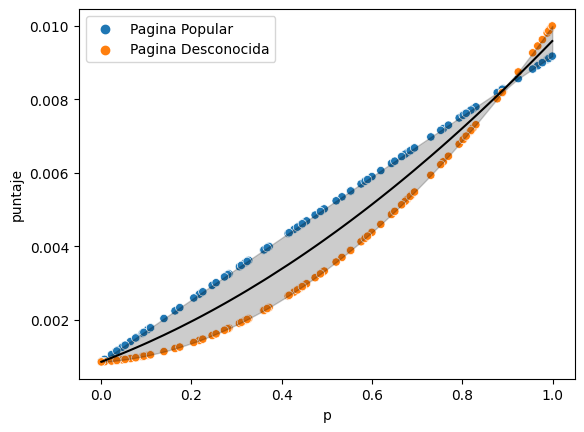

In [385]:
 # Obtengo todos los datos de un experimento
exp_one = exp_rorl[exp_rorl["n_exp"] == n_exps[2]]
one_ref_one_lot_data = []

# Tomo cada fila
for i in range(0, len(exp_one)):
    clear_output(wait=True)
    display("Numero de iteracion es: " + str(i))

    item = exp_one.iloc[i] 
    # Obtengo el data para tener el nodo central

    # Obtengo la probabilidad
    p_valor = item["p-valor"]

    [nodo_central, nodo_ref_central] = obtener_nodos_grupos(item["path"])

    # Leemos los resultados del experimento
    lst = []
    with open(item["path-out"]) as f:
        lst = [float(x) for x in f.read().split()]

    # Tengo la lista de los valores, ahora solo me queda buscar aquel que me sirva

    # Accedo con el valor de interes
    valor_central = lst[nodo_central]
    valor_ref_central = lst[nodo_ref_central]

    # Armo una tupla con ese valor y lo guardo en un arreglo
    one_ref_one_lot_data.append([p_valor, valor_central, "Pagina Popular"])
    one_ref_one_lot_data.append([p_valor, valor_ref_central, "Pagina Desconocida"])

paleta = ["blue", "orange"]

df_rorl_res = pd.DataFrame(one_ref_one_lot_data, columns=["p", "puntaje", "indice"]);
# df_resultados.to_csv("resultados/resultado-ref.csv");

# Lineplot
fig = sns.scatterplot(data=df_rorl_res, x='p', y='puntaje', hue="indice");
fig = sns.lineplot(data=df_rorl_res, x='p', y='puntaje', color="black");

fig.set(xlabel='p', ylabel='puntaje');
plt.savefig("graficos/caso_ref-one-ref-lot-3.svg");

# Grafico one ref one lot diversity

In [400]:
exp_rorl = pg_resultados[(pg_resultados["dataset"]=="ref-one-ref-lot-diversity")].copy();
n_exps = exp_rorl["n_exp"].unique()

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27]


### Experimento 1

### Experimento 2

'Numero de iteracion es: 99'

instancias/ref-one-ref-lot-diversity/ref-one-ref-lot-diversity-14/Test-ref-one-ref-lot-diversity-14.txt.out-99


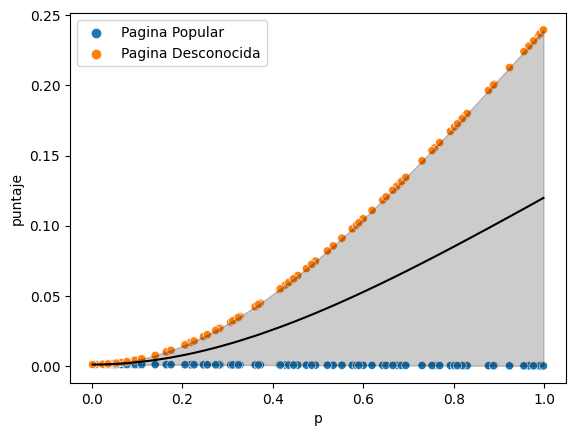

In [403]:
 # Obtengo todos los datos de un experimento
exp_one = exp_rorl[exp_rorl["n_exp"] == n_exps[1]]
one_ref_one_lot_data = []

# Tomo cada fila
for i in range(0, len(exp_one)):
    clear_output(wait=True)
    display("Numero de iteracion es: " + str(i))

    item = exp_one.iloc[i] 
    # Obtengo el data para tener el nodo central

    # Obtengo la probabilidad
    p_valor = item["p-valor"]

    [nodo_central, nodo_ref_central] = obtener_nodos_grupos(item["path"])

    # Leemos los resultados del experimento
    lst = []
    print(item["path-out"])
    with open(item["path-out"]) as f:
        lst = [float(x) for x in f.read().split()]

    # Tengo la lista de los valores, ahora solo me queda buscar aquel que me sirva

    # Accedo con el valor de interes
    valor_central = lst[nodo_central]
    valor_ref_central = lst[nodo_ref_central]

    # Armo una tupla con ese valor y lo guardo en un arreglo
    one_ref_one_lot_data.append([p_valor, valor_central, "Pagina Popular"])
    one_ref_one_lot_data.append([p_valor, valor_ref_central, "Pagina Desconocida"])

paleta = ["blue", "orange"]

df_rorl_res = pd.DataFrame(one_ref_one_lot_data, columns=["p", "puntaje", "indice"]);
# df_resultados.to_csv("resultados/resultado-ref.csv");

# Lineplot
fig = sns.scatterplot(data=df_rorl_res, x='p', y='puntaje', hue="indice");
fig = sns.lineplot(data=df_rorl_res, x='p', y='puntaje', color="black");

fig.set(xlabel='p', ylabel='puntaje');
plt.savefig("graficos/caso_ref-one-ref-lot-diversity-2.svg");

### Experimento 3

'Numero de iteracion es: 99'

instancias/ref-one-ref-lot-diversity/ref-one-ref-lot-diversity-4/Test-ref-one-ref-lot-diversity-4.txt.out-99


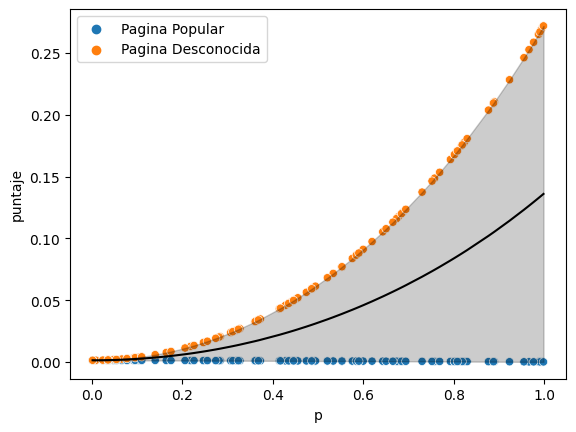

In [394]:
 # Obtengo todos los datos de un experimento
exp_one = exp_rorl[exp_rorl["n_exp"] == n_exps[2]]
print(exp_one)
one_ref_one_lot_data = []

# Tomo cada fila
for i in range(0, len(exp_one)):
    clear_output(wait=True)
    display("Numero de iteracion es: " + str(i))

    item = exp_one.iloc[i] 
    # Obtengo el data para tener el nodo central

    # Obtengo la probabilidad
    p_valor = item["p-valor"]

    [nodo_central, nodo_ref_central] = obtener_nodos_grupos(item["path"])

    # Leemos los resultados del experimento
    lst = []
    print(item["path-out"])
    with open(item["path-out"]) as f:
        lst = [float(x) for x in f.read().split()]

    # Tengo la lista de los valores, ahora solo me queda buscar aquel que me sirva

    # Accedo con el valor de interes
    valor_central = lst[nodo_central]
    valor_ref_central = lst[nodo_ref_central]

    # Armo una tupla con ese valor y lo guardo en un arreglo
    one_ref_one_lot_data.append([p_valor, valor_central, "Pagina Popular"])
    one_ref_one_lot_data.append([p_valor, valor_ref_central, "Pagina Desconocida"])

paleta = ["blue", "orange"]

df_rorl_res = pd.DataFrame(one_ref_one_lot_data, columns=["p", "puntaje", "indice"]);
# df_resultados.to_csv("resultados/resultado-ref.csv");

# Lineplot
fig = sns.scatterplot(data=df_rorl_res, x='p', y='puntaje', hue="indice");
fig = sns.lineplot(data=df_rorl_res, x='p', y='puntaje', color="black");

fig.set(xlabel='p', ylabel='puntaje');
plt.savefig("graficos/caso_ref-one-ref-lot-diversity-3.svg");

# Grafico de grupos

In [121]:
pg_resultados = pd.read_csv("resultados/resultado-grupos.csv");

In [122]:
exp_rorl = pg_resultados[(pg_resultados["dataset"]=="grupos")].copy();
n_exps = exp_rorl["n_exp"].unique()

### Experimento 1

In [123]:
pg_exp_arr_ce = []
pg_exp_arr_se = []

# Obtengo todos los datos de un experimento
pg_exp_num_ce      = exp_rorl[exp_rorl["n_exp"] == n_exps[0]]
pg_exp_num_se   = exp_rorl[exp_rorl["n_exp"] == n_exps[1]]

# Tengo los experimentos, imprimo todos los resultados y ubico especialmente el P en medio de ello
pg_exp_list_ce  = pg_exp_num_ce.values.tolist();
pg_exp_list_se  = pg_exp_num_se.values.tolist();

pg_exp_arr = []
# Tomo cada fila
# Se que len(pg_exp_num) == len(pg_exp_num_se)
for i in range(0, len(pg_exp_list_ce)):

    item_se = pg_exp_list_se[i]
    item_ce = pg_exp_list_ce[i]

    # Obtengamos la información en general
    path_data = str(item_ce[5]).split('.txt')[0]
    path_data = F"{path_data}-data.txt"
    file_data = open(F"{path_data}", "r")
    
    # Obtenemos los nodos centrales. Es decir, los importantes
    Lines = (file_data.readlines())[1:]
    item_nodes = []
        
    for j in range(0, len(Lines)):
        item_tuple = Lines[j].split('\n')
        item_tuple = item_tuple[0].split(" ")
        if(len(item_tuple) > 1):
            item_nodes.append(item_tuple[0])
            
    # Obtengo el p-valor
    p_value = item_se[4]
    
    # Tenemos todo, ahora queda obtener los resultados en general
    
    path_res_se = F"{item_se[6]}"
    path_res_ce = F"{item_ce[6]}"

    # Leemos los resultados de la matriz sin enlace
    lst_se = []
    with open(path_res_se) as f:
        lst_se = [float(x) for x in f.read().split()]
        
    # Leemos los resultados de la matriz con enlace
    lst_ce = []
    with open(path_res_ce) as f:
        lst_ce = [float(x) for x in f.read().split()]
        
    # Ya tenemos todo, ahora nos queda ver que hay que hacer con lo demás
    
    # Recorro los nodos centrales y accedo por ellos al nodo respectivo

    for nodo in item_nodes:
        node = int(nodo)
        
        pg_exp_arr_se.append([p_value, lst_se[node], "Nodo sin Enlaces"])
        pg_exp_arr_ce.append([p_value, lst_ce[node], "Nodo con Enlaces"])

#paleta = ["blue", "orange"]

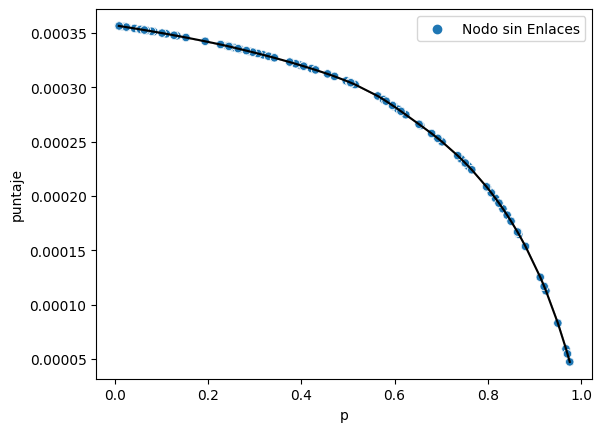

In [144]:
df_grupos_res = pd.DataFrame(pg_exp_arr_se, columns=["p", "puntaje", "indice"]);
#df_grupos_res.to_csv("resultados/resultado-grupos-res.csv");

# Lineplot
fig = sns.scatterplot(data=df_grupos_res, x='p', y='puntaje', hue="indice");
fig = sns.lineplot(data=df_grupos_res, x='p', y='puntaje', color="black");

fig.set(xlabel='p', ylabel='puntaje');
plt.savefig("graficos/caso_grupos-a-sin-enlace.svg");

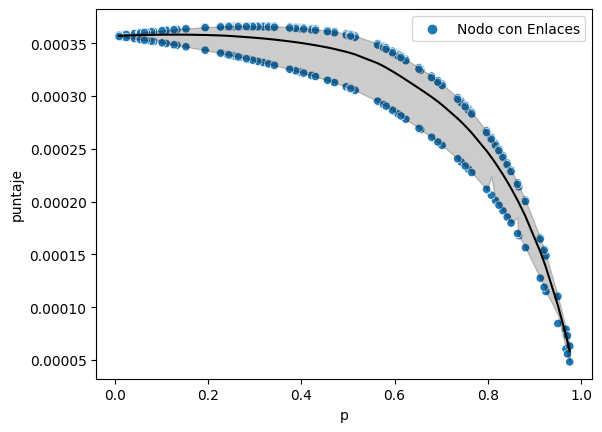

In [145]:
df_grupos_res = pd.DataFrame(pg_exp_arr_ce, columns=["p", "puntaje", "indice"]);
#df_grupos_res.to_csv("resultados/resultado-grupos-res.csv");

# Lineplot
fig = sns.scatterplot(data=df_grupos_res, x='p', y='puntaje', hue="indice");
fig = sns.lineplot(data=df_grupos_res, x='p', y='puntaje', color="black");

fig.set(xlabel='p', ylabel='puntaje');
plt.savefig("graficos/caso_grupos-a-con-enlace.svg");

### Experimento 2

In [147]:
pg_exp_arr_ce = []
pg_exp_arr_se = []

# Obtengo todos los datos de un experimento
pg_exp_num_ce      = exp_rorl[exp_rorl["n_exp"] == n_exps[2]]
pg_exp_num_se   = exp_rorl[exp_rorl["n_exp"] == n_exps[3]]

# Tengo los experimentos, imprimo todos los resultados y ubico especialmente el P en medio de ello
pg_exp_list_ce  = pg_exp_num_ce.values.tolist();
pg_exp_list_se  = pg_exp_num_se.values.tolist();

pg_exp_arr_ce = []
pg_exp_arr_se = []
# Tomo cada fila
# Se que len(pg_exp_num) == len(pg_exp_num_se)
for i in range(0, len(pg_exp_list_ce)):

    item_se = pg_exp_list_se[i]
    item_ce = pg_exp_list_ce[i]

    # Obtengamos la información en general
    path_data = str(item_ce[5]).split('.txt')[0]
    path_data = F"{path_data}-data.txt"
    file_data = open(F"{path_data}", "r")
    
    # Obtenemos los nodos centrales. Es decir, los importantes
    Lines = (file_data.readlines())[1:]
    item_nodes = []
        
    for j in range(0, len(Lines)):
        item_tuple = Lines[j].split('\n')
        item_tuple = item_tuple[0].split(" ")
        if(len(item_tuple) > 1):
            item_nodes.append(item_tuple[0])
            
    # Obtengo el p-valor
    p_value = item_se[4]
    
    # Tenemos todo, ahora queda obtener los resultados en general
    
    path_res_se = F"{item_se[6]}"
    path_res_ce = F"{item_ce[6]}"

    # Leemos los resultados de la matriz sin enlace
    lst_se = []
    with open(path_res_se) as f:
        lst_se = [float(x) for x in f.read().split()]
        
    # Leemos los resultados de la matriz con enlace
    lst_ce = []
    with open(path_res_ce) as f:
        lst_ce = [float(x) for x in f.read().split()]
        
    # Ya tenemos todo, ahora nos queda ver que hay que hacer con lo demás
    
    # Recorro los nodos centrales y accedo por ellos al nodo respectivo

    for nodo in item_nodes:
        node = int(nodo)
        
        pg_exp_arr_se.append([p_value, lst_se[node], "Nodo sin Enlaces"])
        pg_exp_arr_ce.append([p_value, lst_ce[node], "Nodo con Enlaces"])

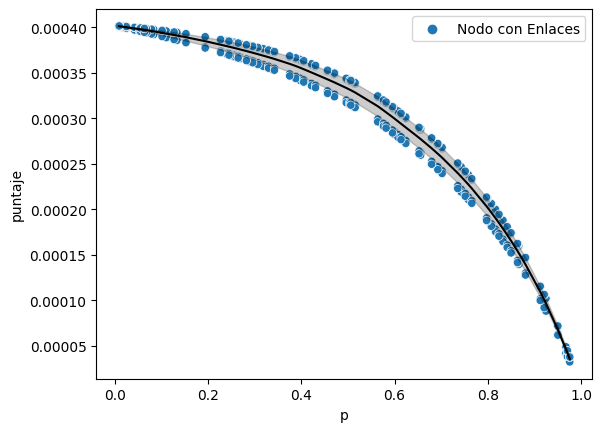

In [148]:
df_grupos_res = pd.DataFrame(pg_exp_arr_ce, columns=["p", "puntaje", "indice"]);
#df_grupos_res.to_csv("resultados/resultado-grupos.csv");

# Lineplot
fig = sns.scatterplot(data=df_grupos_res, x='p', y='puntaje', hue="indice");
fig = sns.lineplot(data=df_grupos_res, x='p', y='puntaje', color="black");

fig.set(xlabel='p', ylabel='puntaje');
plt.savefig("graficos/caso_grupos-b-con-enlace.svg");

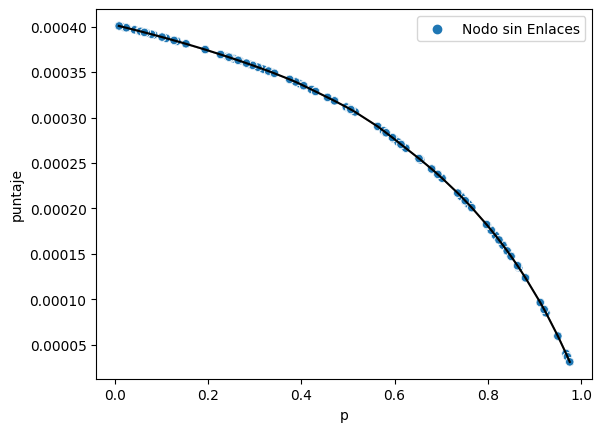

In [149]:
df_grupos_res = pd.DataFrame(pg_exp_arr_se, columns=["p", "puntaje", "indice"]);
#df_grupos_res.to_csv("resultados/resultado-grupos.csv");

# Lineplot
fig = sns.scatterplot(data=df_grupos_res, x='p', y='puntaje', hue="indice");
fig = sns.lineplot(data=df_grupos_res, x='p', y='puntaje', color="black");

fig.set(xlabel='p', ylabel='puntaje');
plt.savefig("graficos/caso_grupos-b-sin-enlace.svg");

## Test referenciadas new

In [433]:
pg_resultados = pd.read_csv("resultados/resultado-new.csv");

In [434]:
exp_referenciadas = pg_resultados[(pg_resultados["dataset"]=="referenciadas-new")].copy();
n_exps = exp_referenciadas["n_exp"].unique()
n_exps

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

In [435]:
n_exps
exps = []
for exp in n_exps:
    exps.append(exp)
    
n_exps = random.sample(exps, 5)
n_exps

[9, 8, 5, 1, 10]

In [517]:
num = 0
# Vamos cada experimento por cada caso

# Obtengo todos los datos de un experimento
referenciadas_new_ce   = exp_referenciadas[exp_referenciadas["n_exp"] == 7]
referenciadas_new_se   = exp_referenciadas[exp_referenciadas["n_exp"] == 8]

pg_exp_list_ce  = referenciadas_new_ce.values.tolist();
pg_exp_list_se  = referenciadas_new_se.values.tolist();

print(pg_exp_list_ce[0])
print(pg_exp_list_se[0])

pg_exp_arr_ce = []
pg_exp_arr_se = []

pg_arr_res_new = []
# Tomo cada fila
# Se que len(pg_exp_num) == len(pg_exp_num_se)
for i in range(0, len(pg_exp_list_ce)):

    item_se = pg_exp_list_se[i]
    item_ce = pg_exp_list_ce[i]

    # Obtengamos la información en general
    path_data = str(item_ce[5]).split('.txt')[0]
    number = (path_data.split("-"))[8]
    path_data_end = (path_data.split('-con'))[0]
    path_data = F"instancias/referenciadas-new/referenciadas-new-5/Test-referenciadas-new-5-data.txt"
    file_data = open(F"{path_data}", "r")
        
    # Obtenemos los nodos centrales. Es decir, los importantes
    Lines = (file_data.readlines())
    nodo_central = int(Lines[0])

    # Leemos los resultados del experimento
    lst_ce = []
    with open(item_ce[6]) as f:
        lst_ce = [float(x) for x in f.read().split()]

    lst_se = []
    with open(item_se[6]) as f:
        lst_se = [float(x) for x in f.read().split()]

    # De la lista de resultados tomo el nodo de interes
    valor_interes_ce = lst_ce[nodo_central]
    valor_interes_se = lst_se[nodo_central]      
            
    # Obtengo el p-valor
    p_value = item_se[4]
    
    pg_exp_arr_se.append([p_value, valor_interes_se, "Nodo sin Enlaces"])    
    pg_exp_arr_ce.append([p_value, valor_interes_ce, "Nodo con Enlaces"])

pg_arr_res_new.append(pg_exp_arr_se)
pg_arr_res_new.append(pg_exp_arr_ce)

[7, 'referenciadas-new', 1229, 3121, 0.6897146278678747, 'instancias/referenciadas-new/referenciadas-new-5/Test-referenciadas-new-sin-grupo-5.txt', 'instancias/referenciadas-new/referenciadas-new-5/Test-referenciadas-new-sin-grupo-5.txt.out-0']
[8, 'referenciadas-new', 1229, 3121, 0.6897146278678747, 'instancias/referenciadas-new/referenciadas-new-5/Test-referenciadas-new-con-grupo-5.txt', 'instancias/referenciadas-new/referenciadas-new-5/Test-referenciadas-new-con-grupo-5.txt.out-0']


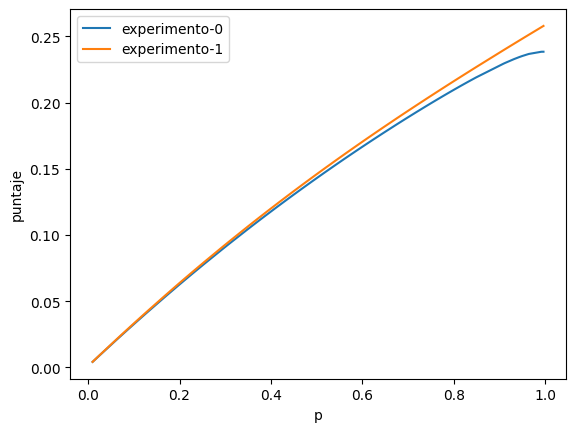

In [516]:
# Imprimo las normas
for i in range(0, len(pg_arr_res)):
    df_referenciadas_new = pd.DataFrame(pg_arr_res_new[i], columns=["p", "puntaje", "indice"]);

    name = F"experimento-{i}"
    # Lineplot
    fig = sns.lineplot(
        data=df_referenciadas_new, 
        x='p', 
        y='puntaje',
        label=name
    );
    #fig = sns.scatterplot(data=pg_unasola_res, x='p', y='puntaje');

fig.set(xlabel='p', ylabel='puntaje');
plt.savefig("graficos/referenciadas-new.svg");

## Experimentos con catedra

In [210]:
fnames = [
"test_15_segundos",
"test_30_segundos",
"test_aleatorio_desordenado",
"test_sin_links",
"test_completo",
"test_trivial"
]

caso_error = []
for file in fnames:
    path_catedra = F"./tests/resultados_catedra/{file}.txt.out";
    path_nuestro = F"./tests/resultados_nuestros/{file}.txt.out";
    
    error_abs = error_absoluto_catedra(path_catedra, path_nuestro)
    caso_error.append([file, error_abs])
    
df_caso_error = pd.DataFrame(caso_error, columns=["Nombre de experimento", "Error Absoluto"]);

df_caso_error

,Nombre de experimento,Error Absoluto
0,test_15_segundos,0.000093
1,test_30_segundos,0.000106
2,test_aleatorio_desordenado,0.000000
3,test_sin_links,0.000000
4,test_completo,0.000000
5,test_trivial,0.000000
